#Cylinder without revolution noisy line elements

Using Bayesian Gaussian process latent variable model to discover a latent space representation of the line elements of a cylinder without revolution.

Made by Ivan De Boi (ivan.deboi at uantwerpen.be, http://www.InViLab.be).

In [6]:
shape_name_string = 'Cylinder without revolution noisy'

# Imports

In [7]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

!pip install GPy
import GPy
from GPy.util import pca
from GPy import kern
GPy.plotting.change_plotting_library('matplotlib')

from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from numpy import genfromtxt

from google.colab import drive
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#use this to adjust the resolution of the pictures etc.
#print(plt.rcParams)  # it will tell you all default setting in Matplotlib
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = [8,6]
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('figure.dpi'))
plt.rcParams['figure.dpi'] = 72.0*5
print(plt.rcParams.get('figure.dpi'))

[6.0, 4.0]
[8.0, 6.0]
72.0
360.0


# Data

In [9]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PhD 3D Sensing/05 GPLVM on set of lines/Line Elements Surface/Line Elements/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
data = genfromtxt(root_path + shape_name_string + ' line elements.csv', delimiter=',')
shape_name_string
Y = data[:,:]
print(Y[0:3,:])
print(Y.shape)

[[-9.92586613e-01 -5.64740156e-04 -1.21538073e-01  9.75050032e-02
   8.13058853e-01 -8.00089419e-01  1.10817575e+00]
 [-9.96070564e-01 -8.89544026e-04 -8.85586217e-02  6.57791048e-02
   8.50475729e-01 -7.48398721e-01  1.08055484e+00]
 [-9.95021105e-01 -2.65957825e-02 -9.60502177e-02  4.59507257e-02
   8.93166363e-01 -7.23334134e-01  1.10498559e+00]]
(6633, 7)


# PCA

In [11]:
# Normalize
scaler = StandardScaler()
scaler.fit(Y)

Yn = scaler.transform(Y)
print(Yn[0:3, :])

# Sanity checks
print("mean y:",Y.mean())
print("std y:", Y.std())
print("mean yn:", Yn.mean())
print("std yn:", Yn.std())

[[-1.50962035 -1.94613853 -3.60046516  0.25358796  1.78101462 -1.28712272
   1.40680521]
 [-1.51424331 -1.94724775 -2.62683056  0.17030389  1.86283128 -1.20570651
   1.35624334]
 [-1.51285075 -2.0350353  -2.84800093  0.11825215  1.95617966 -1.16622815
   1.40096542]]
mean y: 0.15300630819968908
std y: 0.5355322718227236
mean yn: -2.4485115057098926e-18
std yn: 1.0000000000000004


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

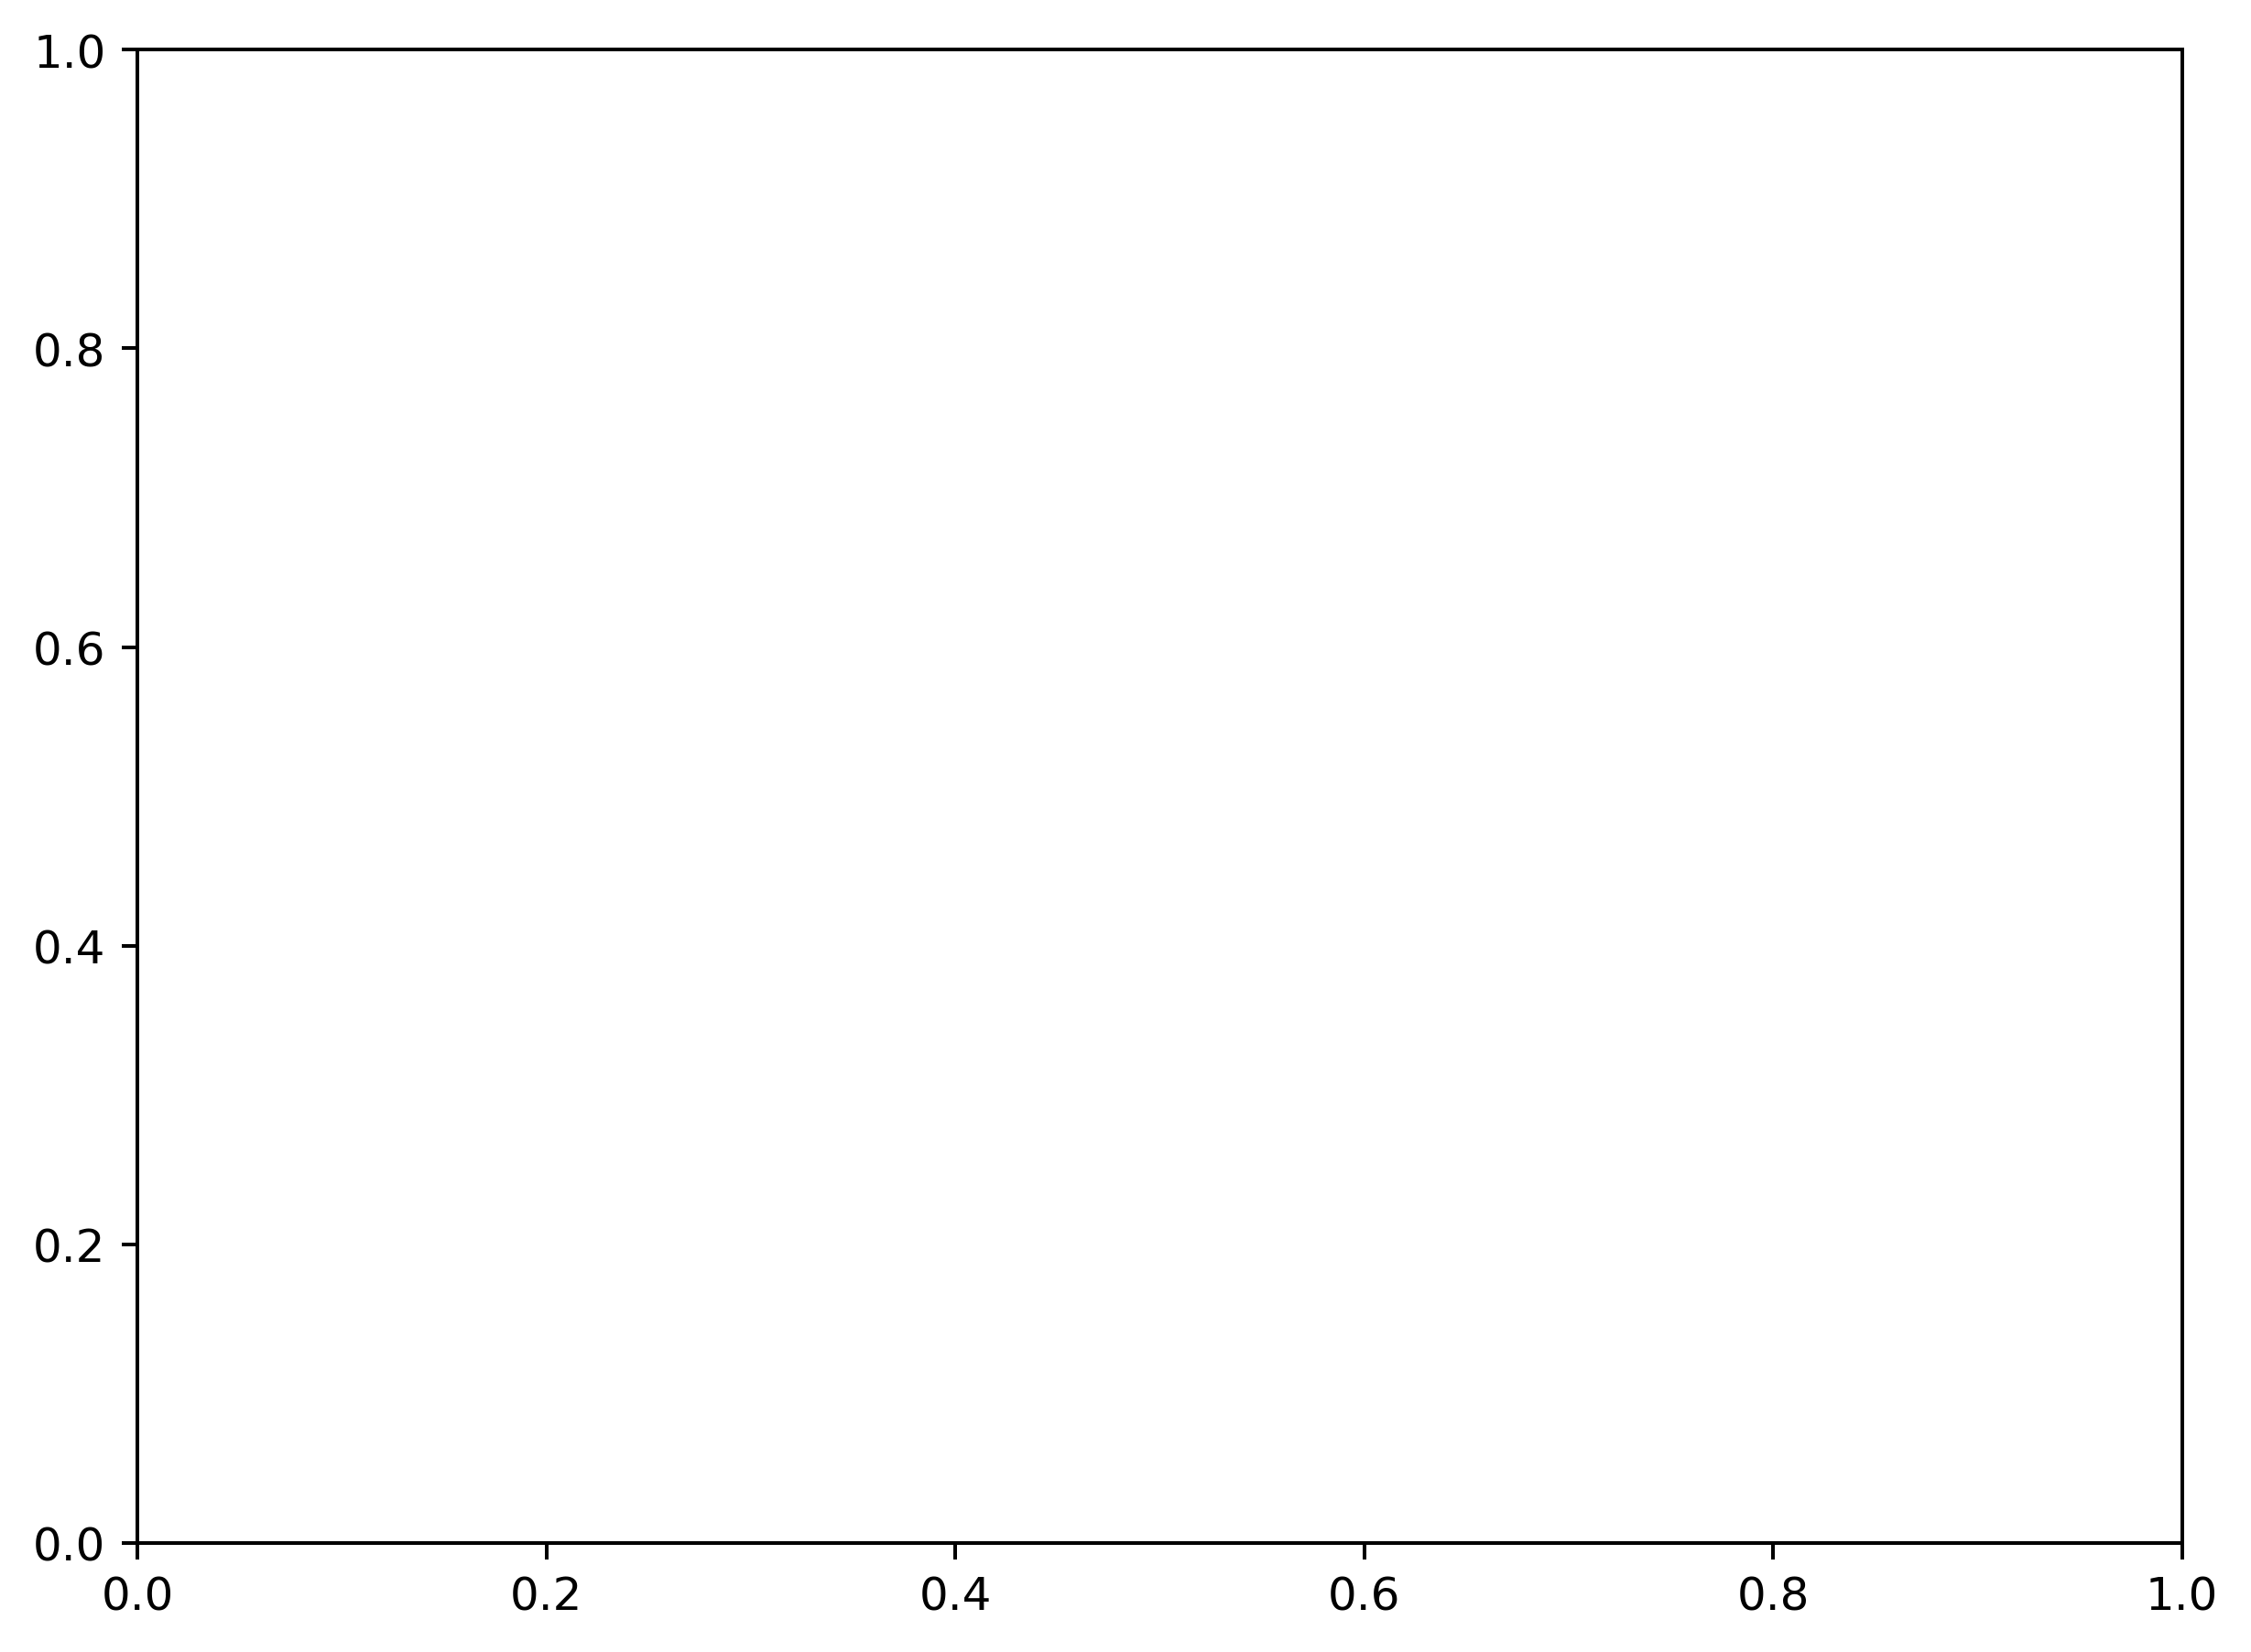

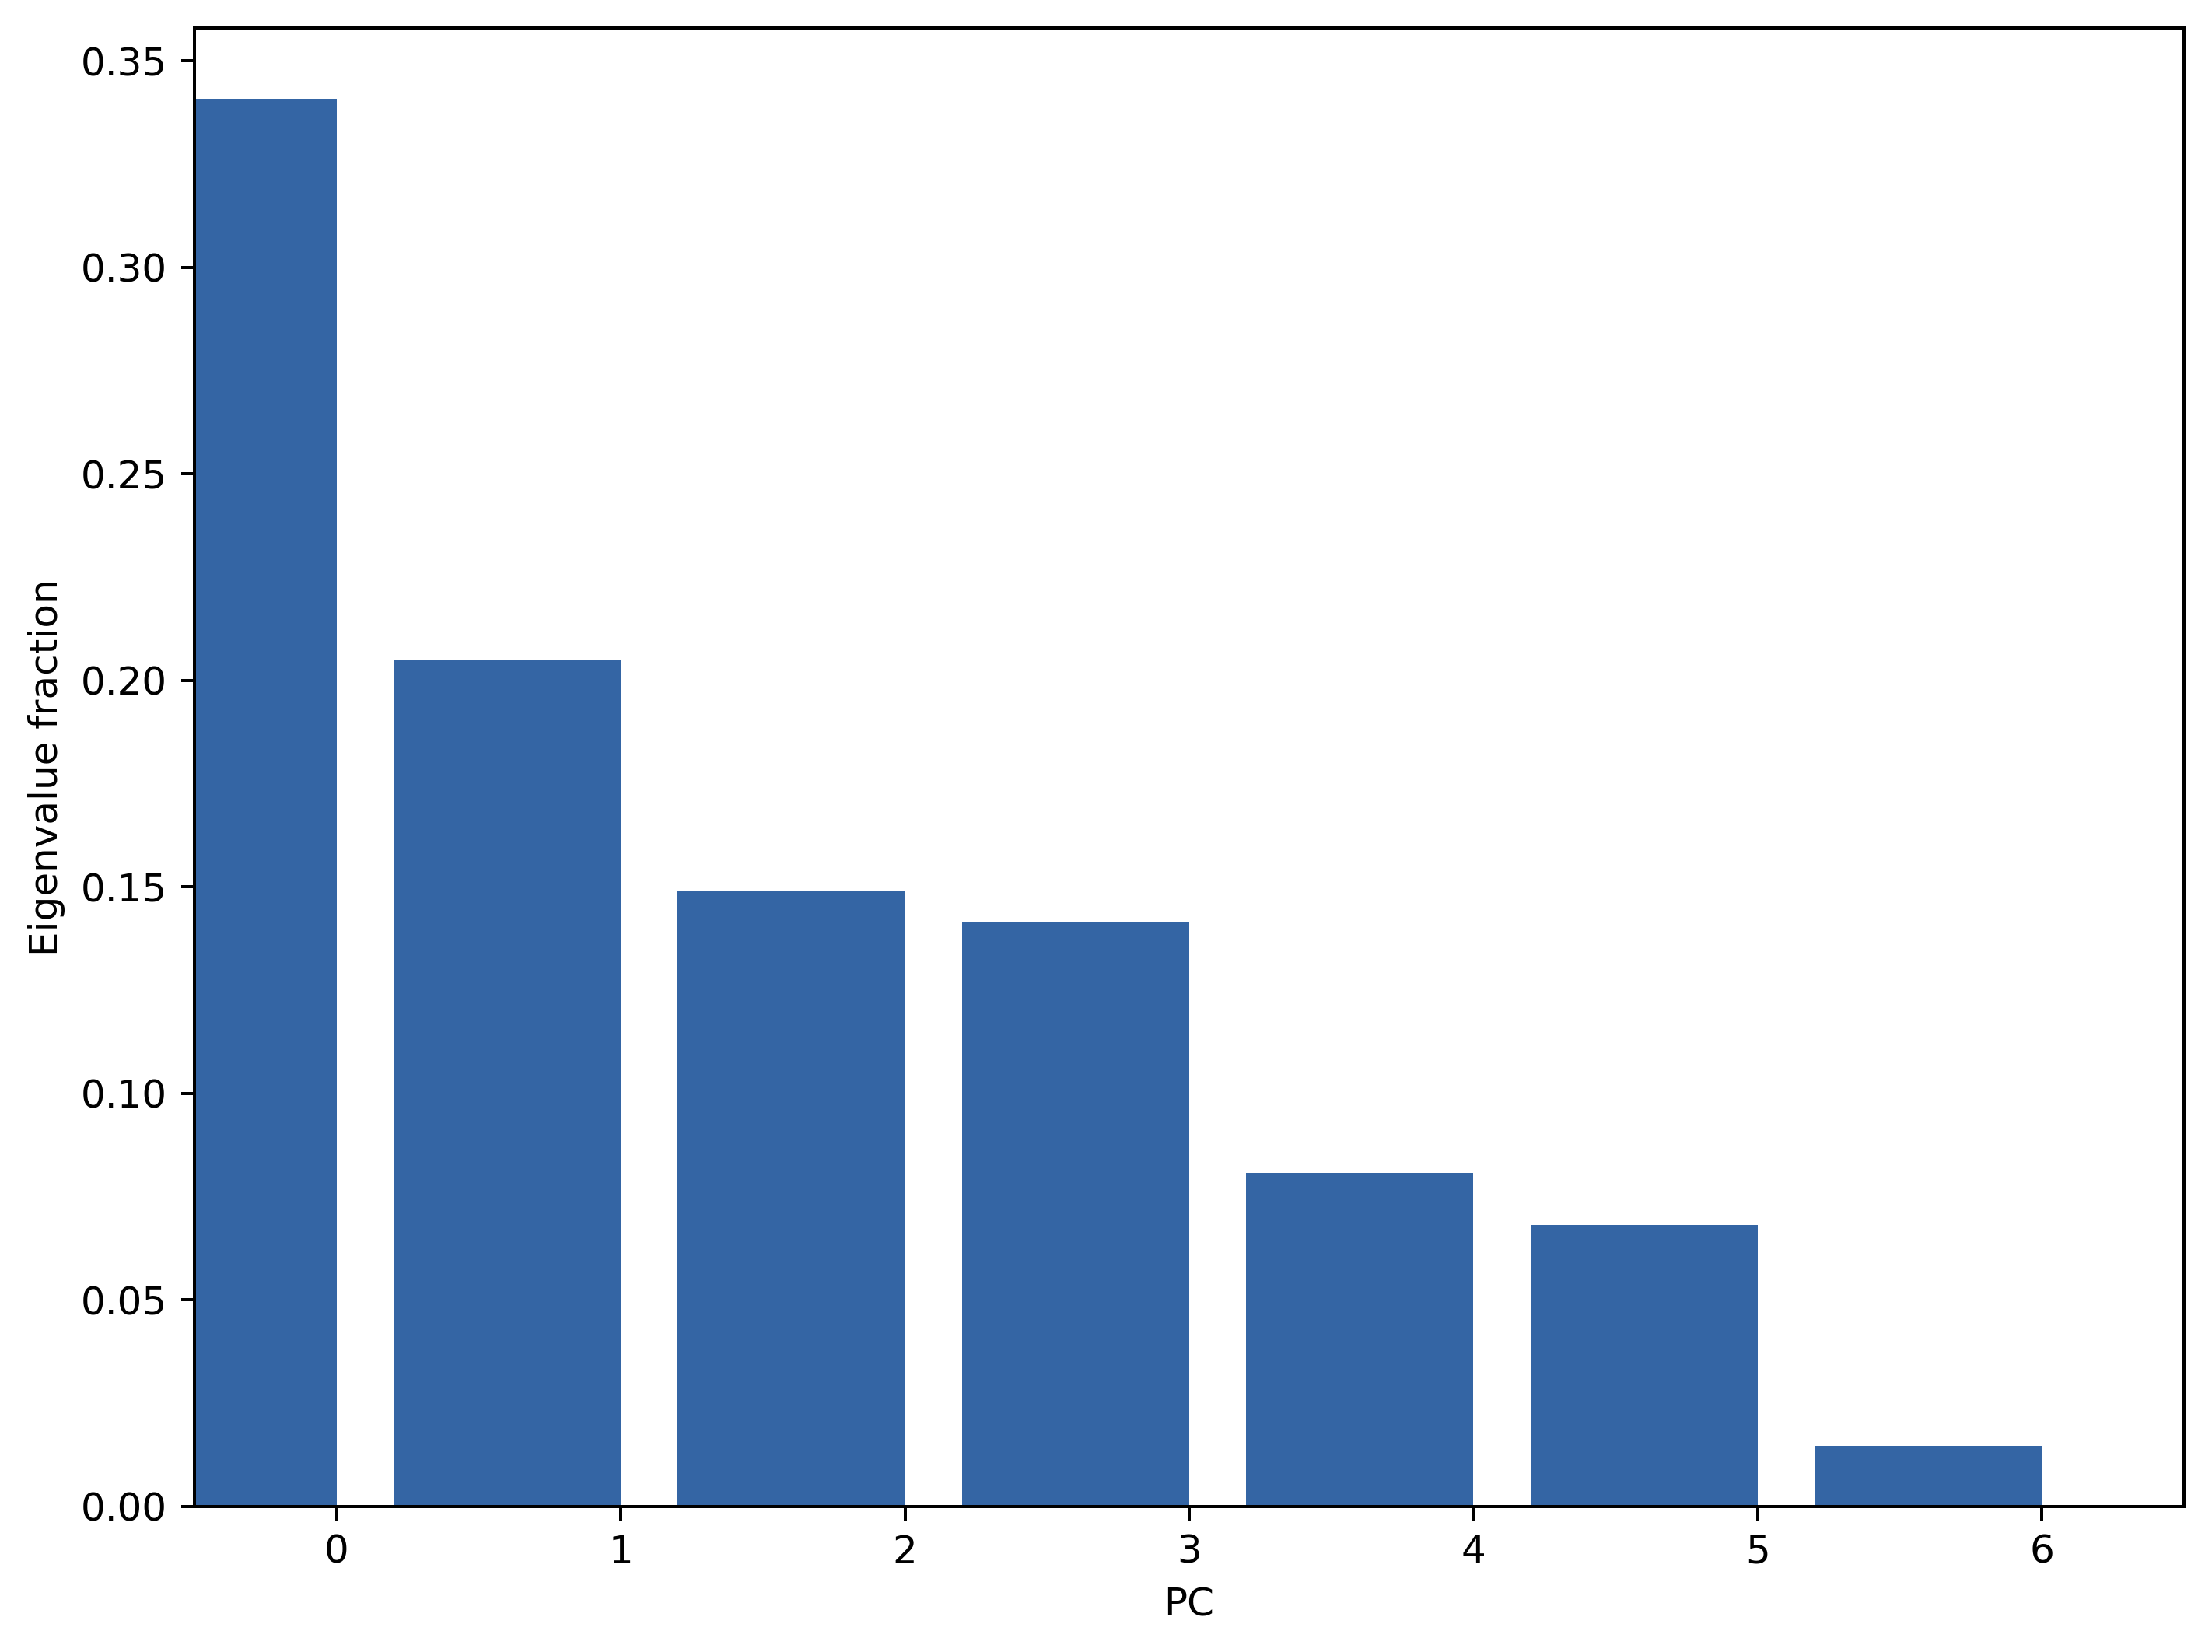

In [12]:
p = pca.PCA(Yn)
# plot first xxx eigenvalue fractions

fig, ax = plt.subplots()
p.plot_fracs(Yn.shape[1]) 

filename = shape_name_string + ' PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

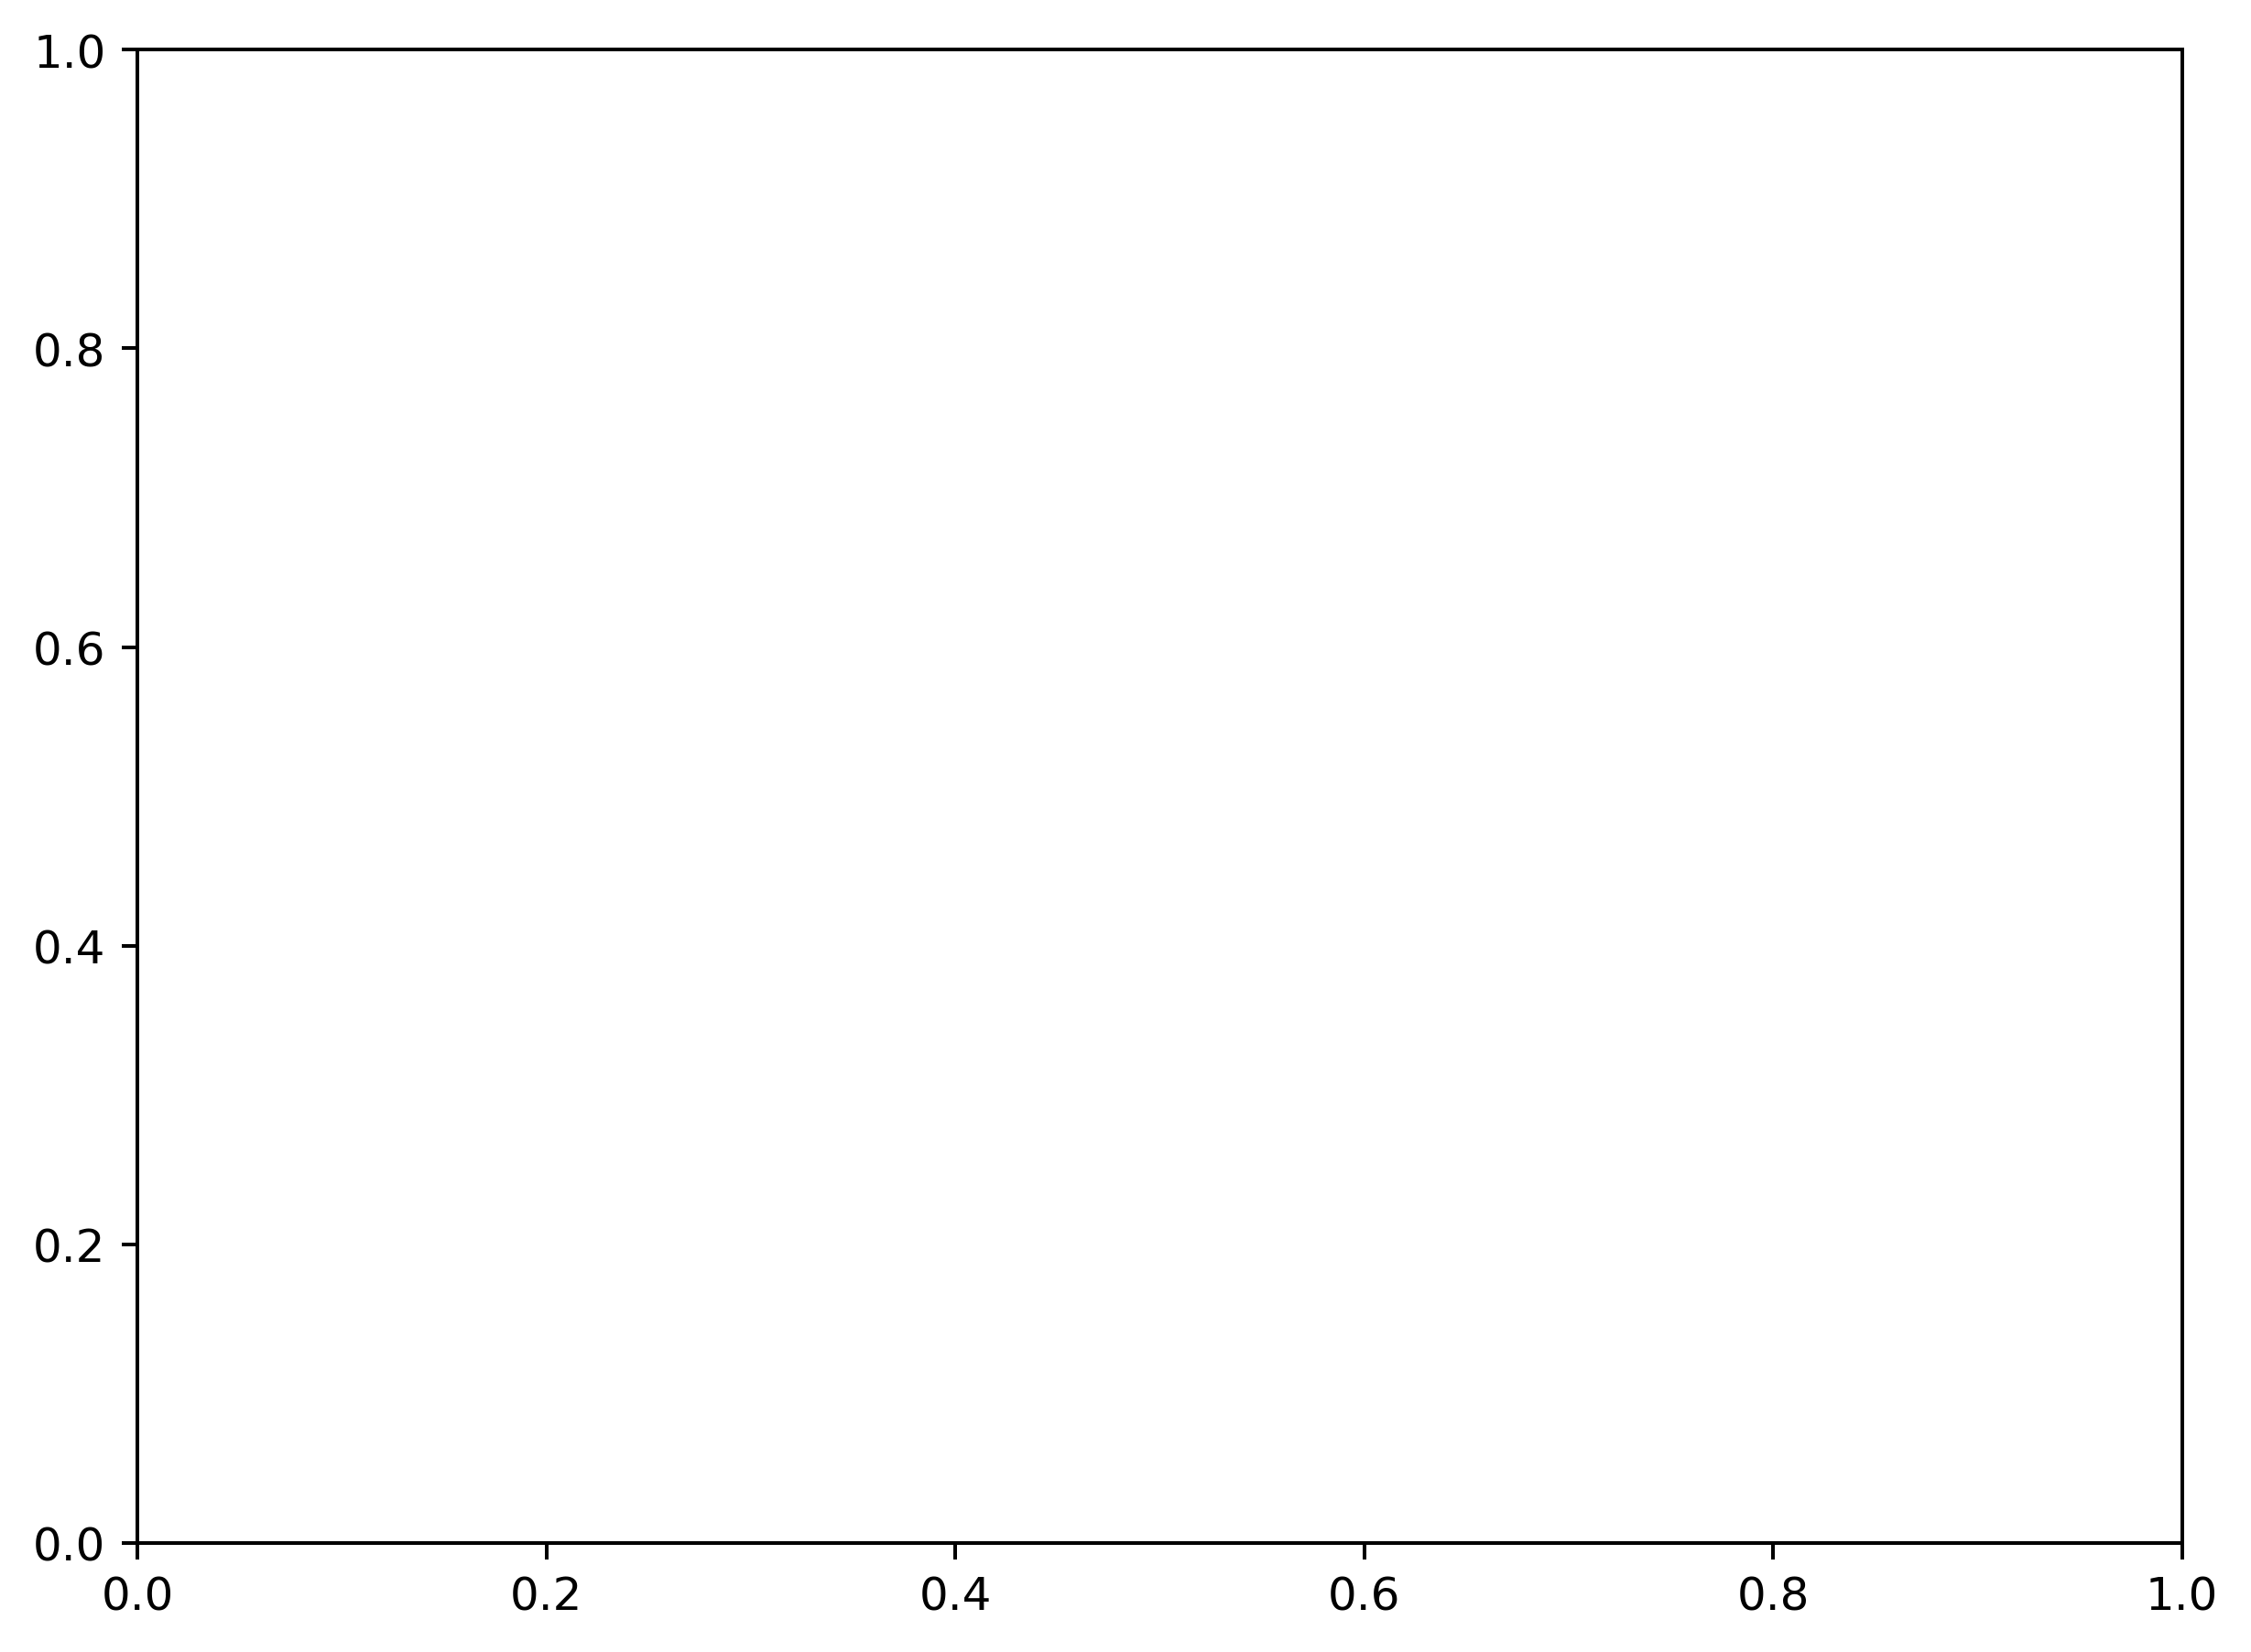

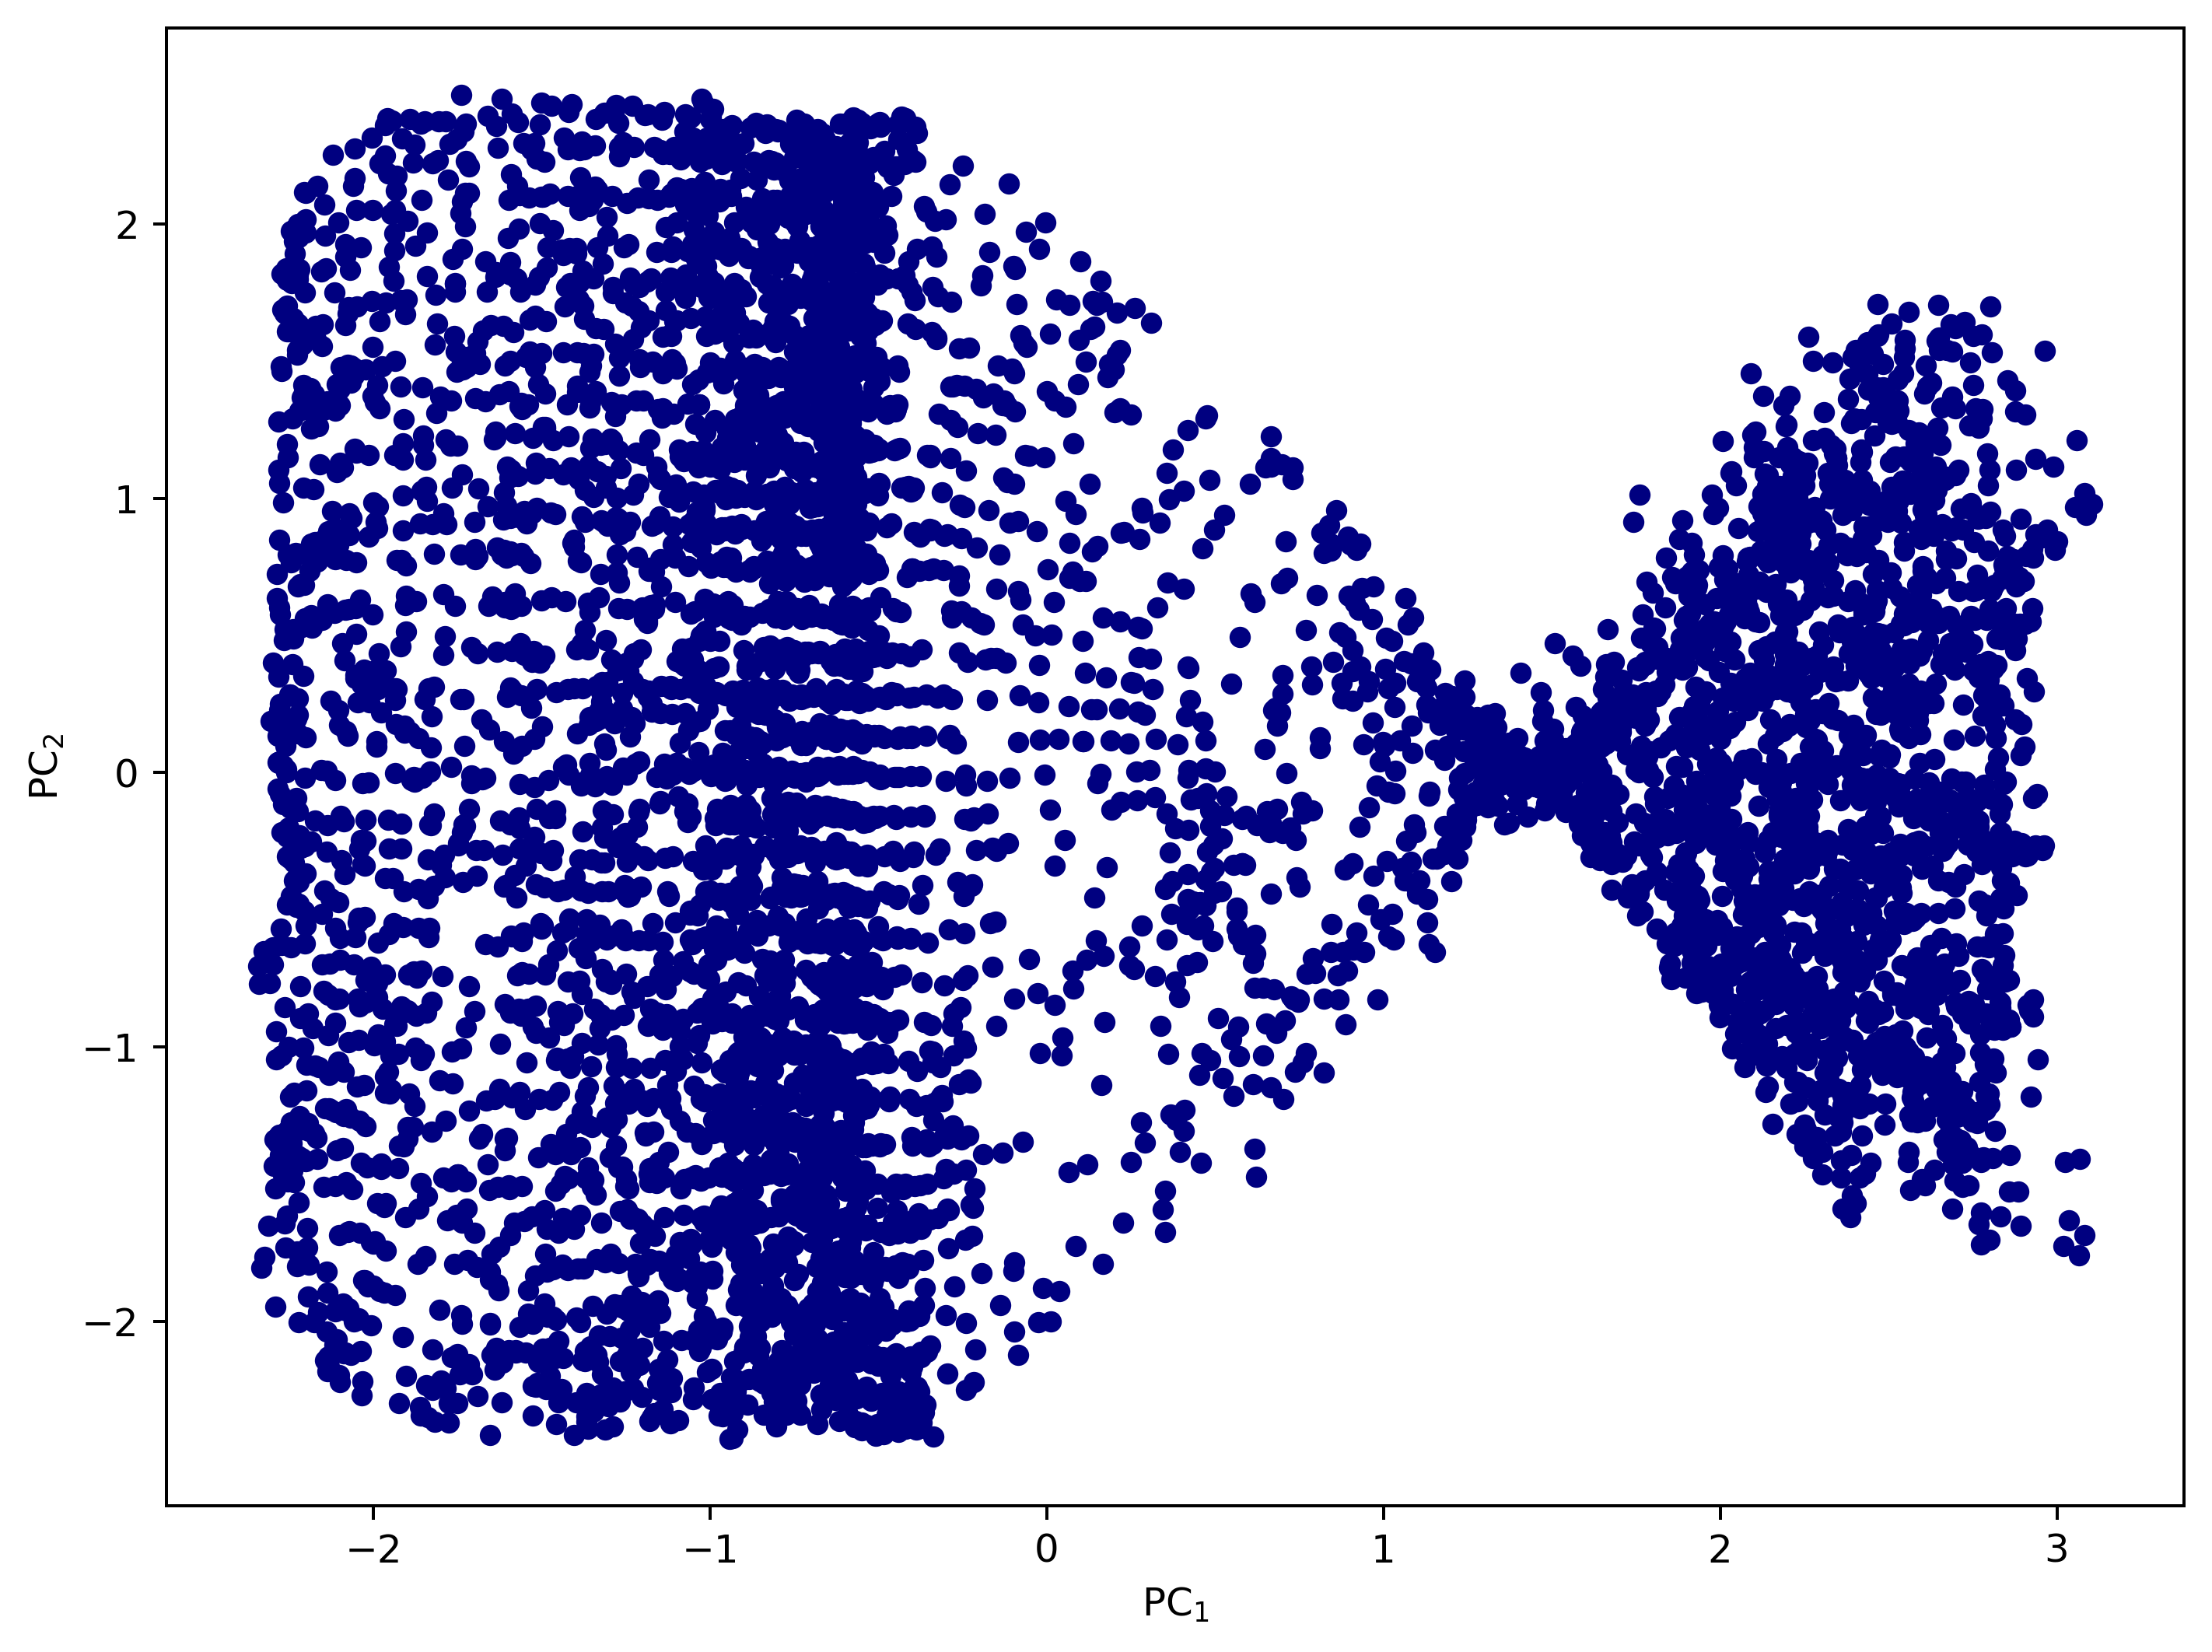

In [13]:
# plot the latent space by PCA

fig, ax = plt.subplots()
p.plot_2d(Yn)

filename = shape_name_string + ' 2D PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

# BGPLVM

In [14]:
max_nr_of_data_points = 2500 #use this line to subsample
#max_nr_of_data_points = Y.shape[0]
Y = Y[np.random.choice(Y.shape[0], max_nr_of_data_points, replace=False), :] #permutation on the datapoints
print(Y.shape)

points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)


plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = points[:, 2])
ax.set_title('Points in training')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' points in training.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
max_nr_of_iters = 20000

init='PCA'
#init='random'

likelihood_variance = 1e-6
likelihood_variance_fix = False #use this to fix the noiselevel

optimizer = 'scg'
optimizer = 'lbfgs'
#optimizer = 'tnc'

num_restarts = 10

input_dim = 7 #Y.shape[1]
num_inducing = 50

In [16]:
k_GPLVM = GPy.kern.RBF(input_dim, ARD = True)

m_GPLVM = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing)

if likelihood_variance_fix:
  m_GPLVM.likelihood.variance = likelihood_variance
  m_GPLVM.likelihood.variance.fix()

m_GPLVM.optimize_restarts(messages=1, num_restarts=num_restarts, max_iters=max_nr_of_iters, optimizer = optimizer) 
print(m_GPLVM) 

Optimization restart 1/10, f = -18714.49973096444


Optimization restart 2/10, f = 14609.55951499208


Optimization restart 3/10, f = 12547.429023641042


Optimization restart 4/10, f = 14609.554732971921


Optimization restart 5/10, f = 14609.55025471792


Optimization restart 6/10, f = 14609.558726400428


Optimization restart 7/10, f = 14609.551679125152


Optimization restart 8/10, f = 14609.551716435544


Optimization restart 9/10, f = 14609.550453562868


Optimization restart 10/10, f = 14609.5502533852

Name : bayesian gplvm
Objective : -18714.49973096444
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (2500, 7)  |               |        
  latent_space.variance    |               (2500, 7)  |      +ve      |        
  inducing_inputs          |                 (50, 7)  |               |        
  rbf.variance             |      0.2668922028670968  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  4.1135632731066494e-05  |      +ve      |        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

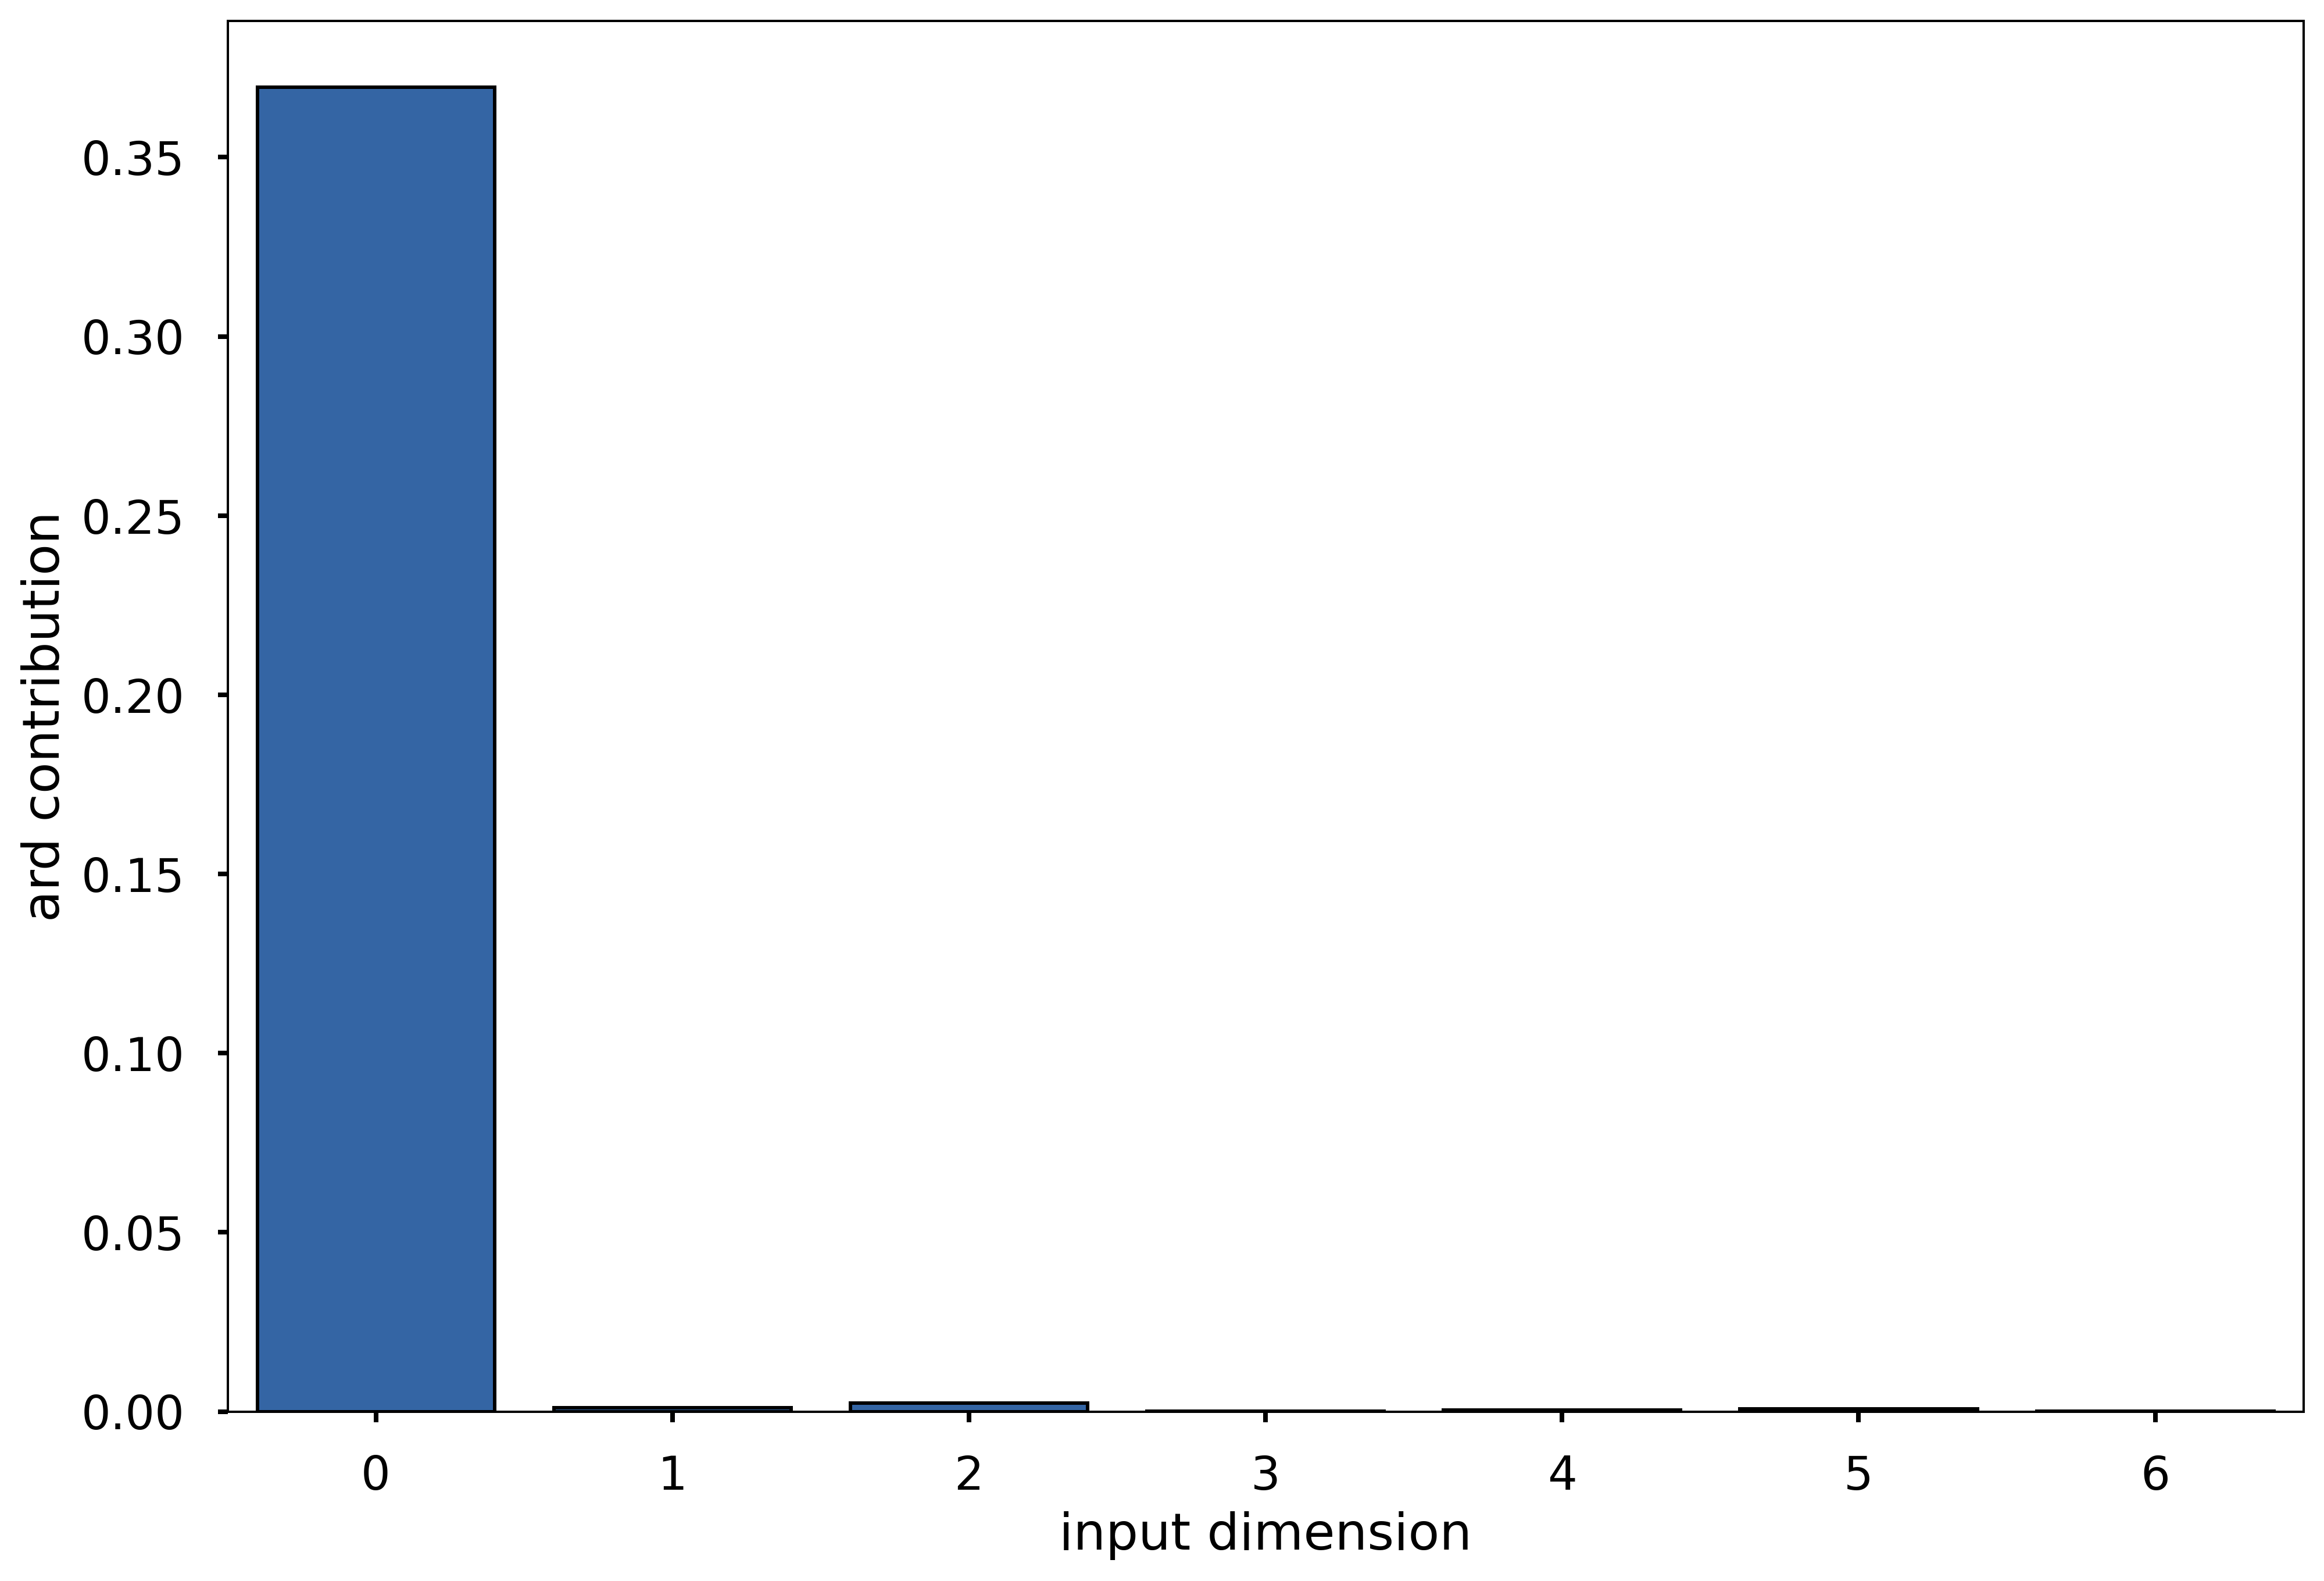

In [17]:
fig, ax = plt.subplots()
m_GPLVM.kern.plot_ARD(ax=ax)

filename = shape_name_string + ' ARD.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [18]:
m_GPLVM.kern.lengthscale #which is the inverse of ARD contribution

bayesian_gplvm.rbf.lengthscale:
Param([  0.84974397,  16.37648637,  10.73971024, 181.96953677,
        27.00692484,  18.29495857, 169.5228931 ])

In [19]:
lengthscales = m_GPLVM.kern.lengthscale.argsort()
input_dimension_1 =lengthscales[0]
input_dimension_2 =lengthscales[1]
input_dimension_3 =lengthscales[2]

print(input_dimension_1)
print(input_dimension_2)
print(input_dimension_3)

0
2
1


In [20]:
latent = m_GPLVM.X.mean 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

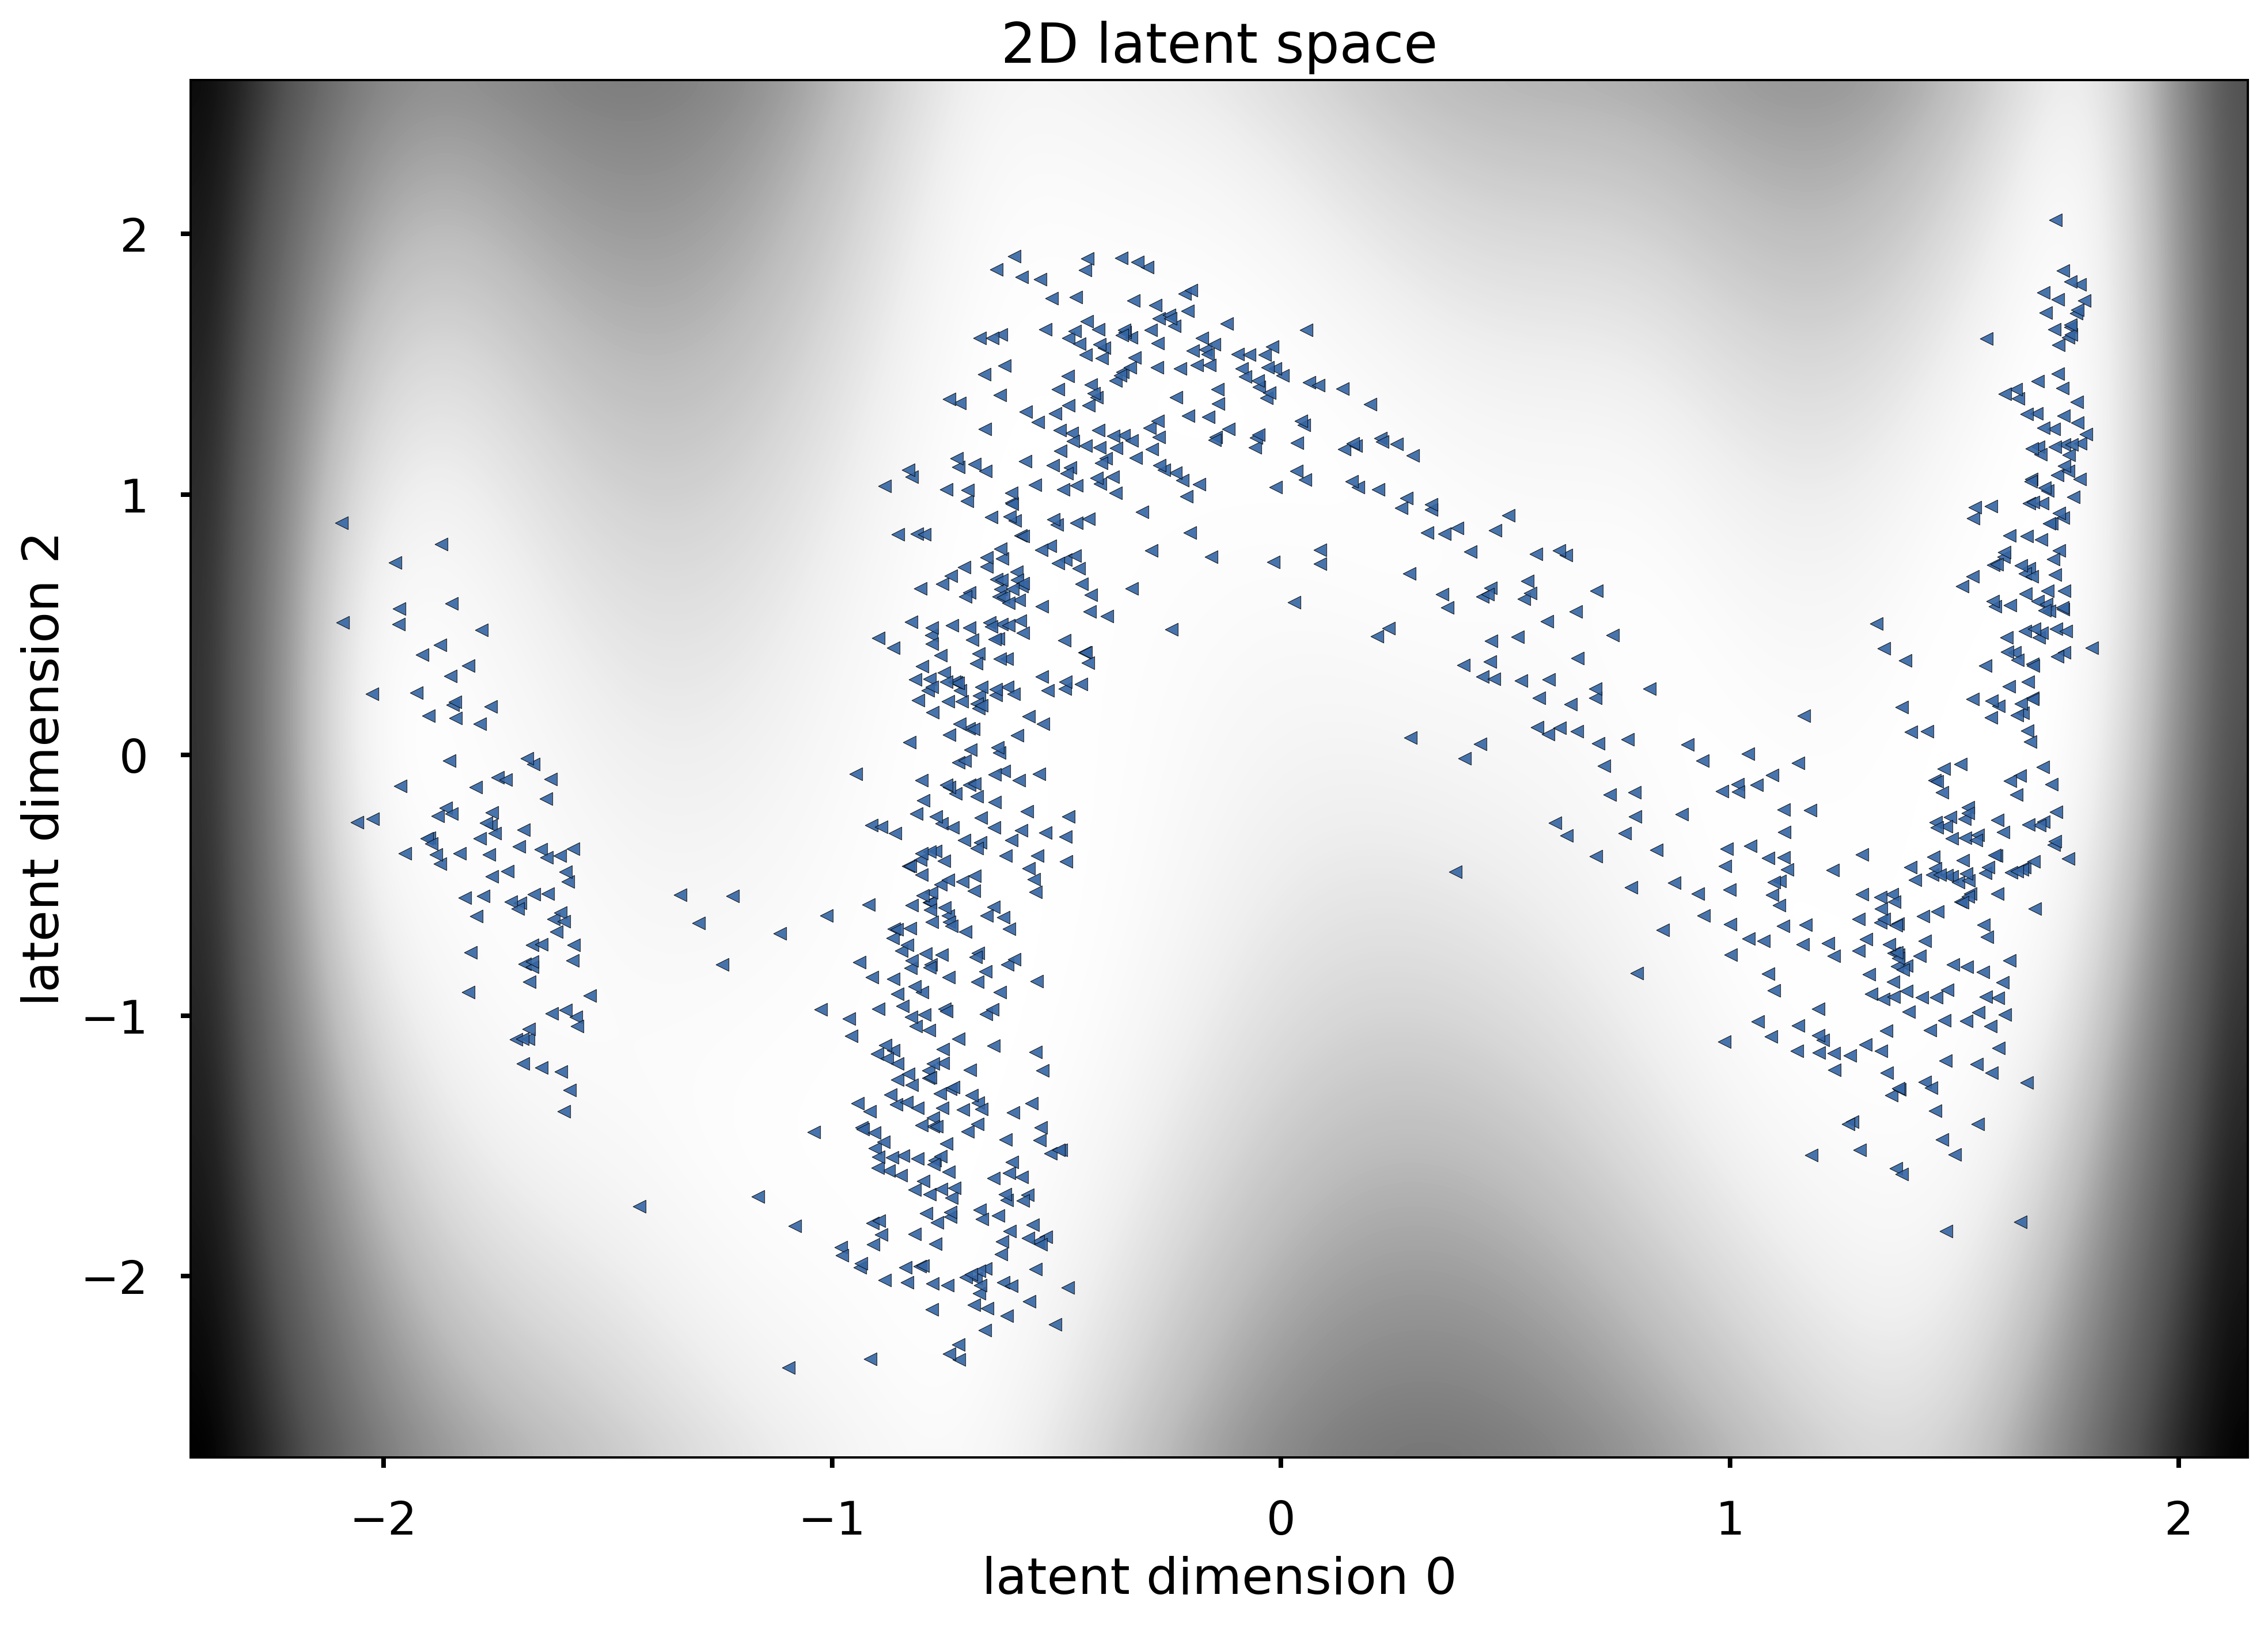

In [21]:
# m_GPLVM.plot_latent(updates=False, legend =True, resolution=100)

fig, ax = plt.subplots()
ax.set_title('2D latent space')
labels = Y
m_GPLVM.plot_latent(ax=ax, updates=False, legend =True)
filename = shape_name_string + ' 2D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [22]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=latent[:, 2], y=latent[:,4], z=latent[:, 6],
                                   mode='markers',
                                   marker=dict(size=2, colorscale='Spectral',opacity=0.8)
                                   )])
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

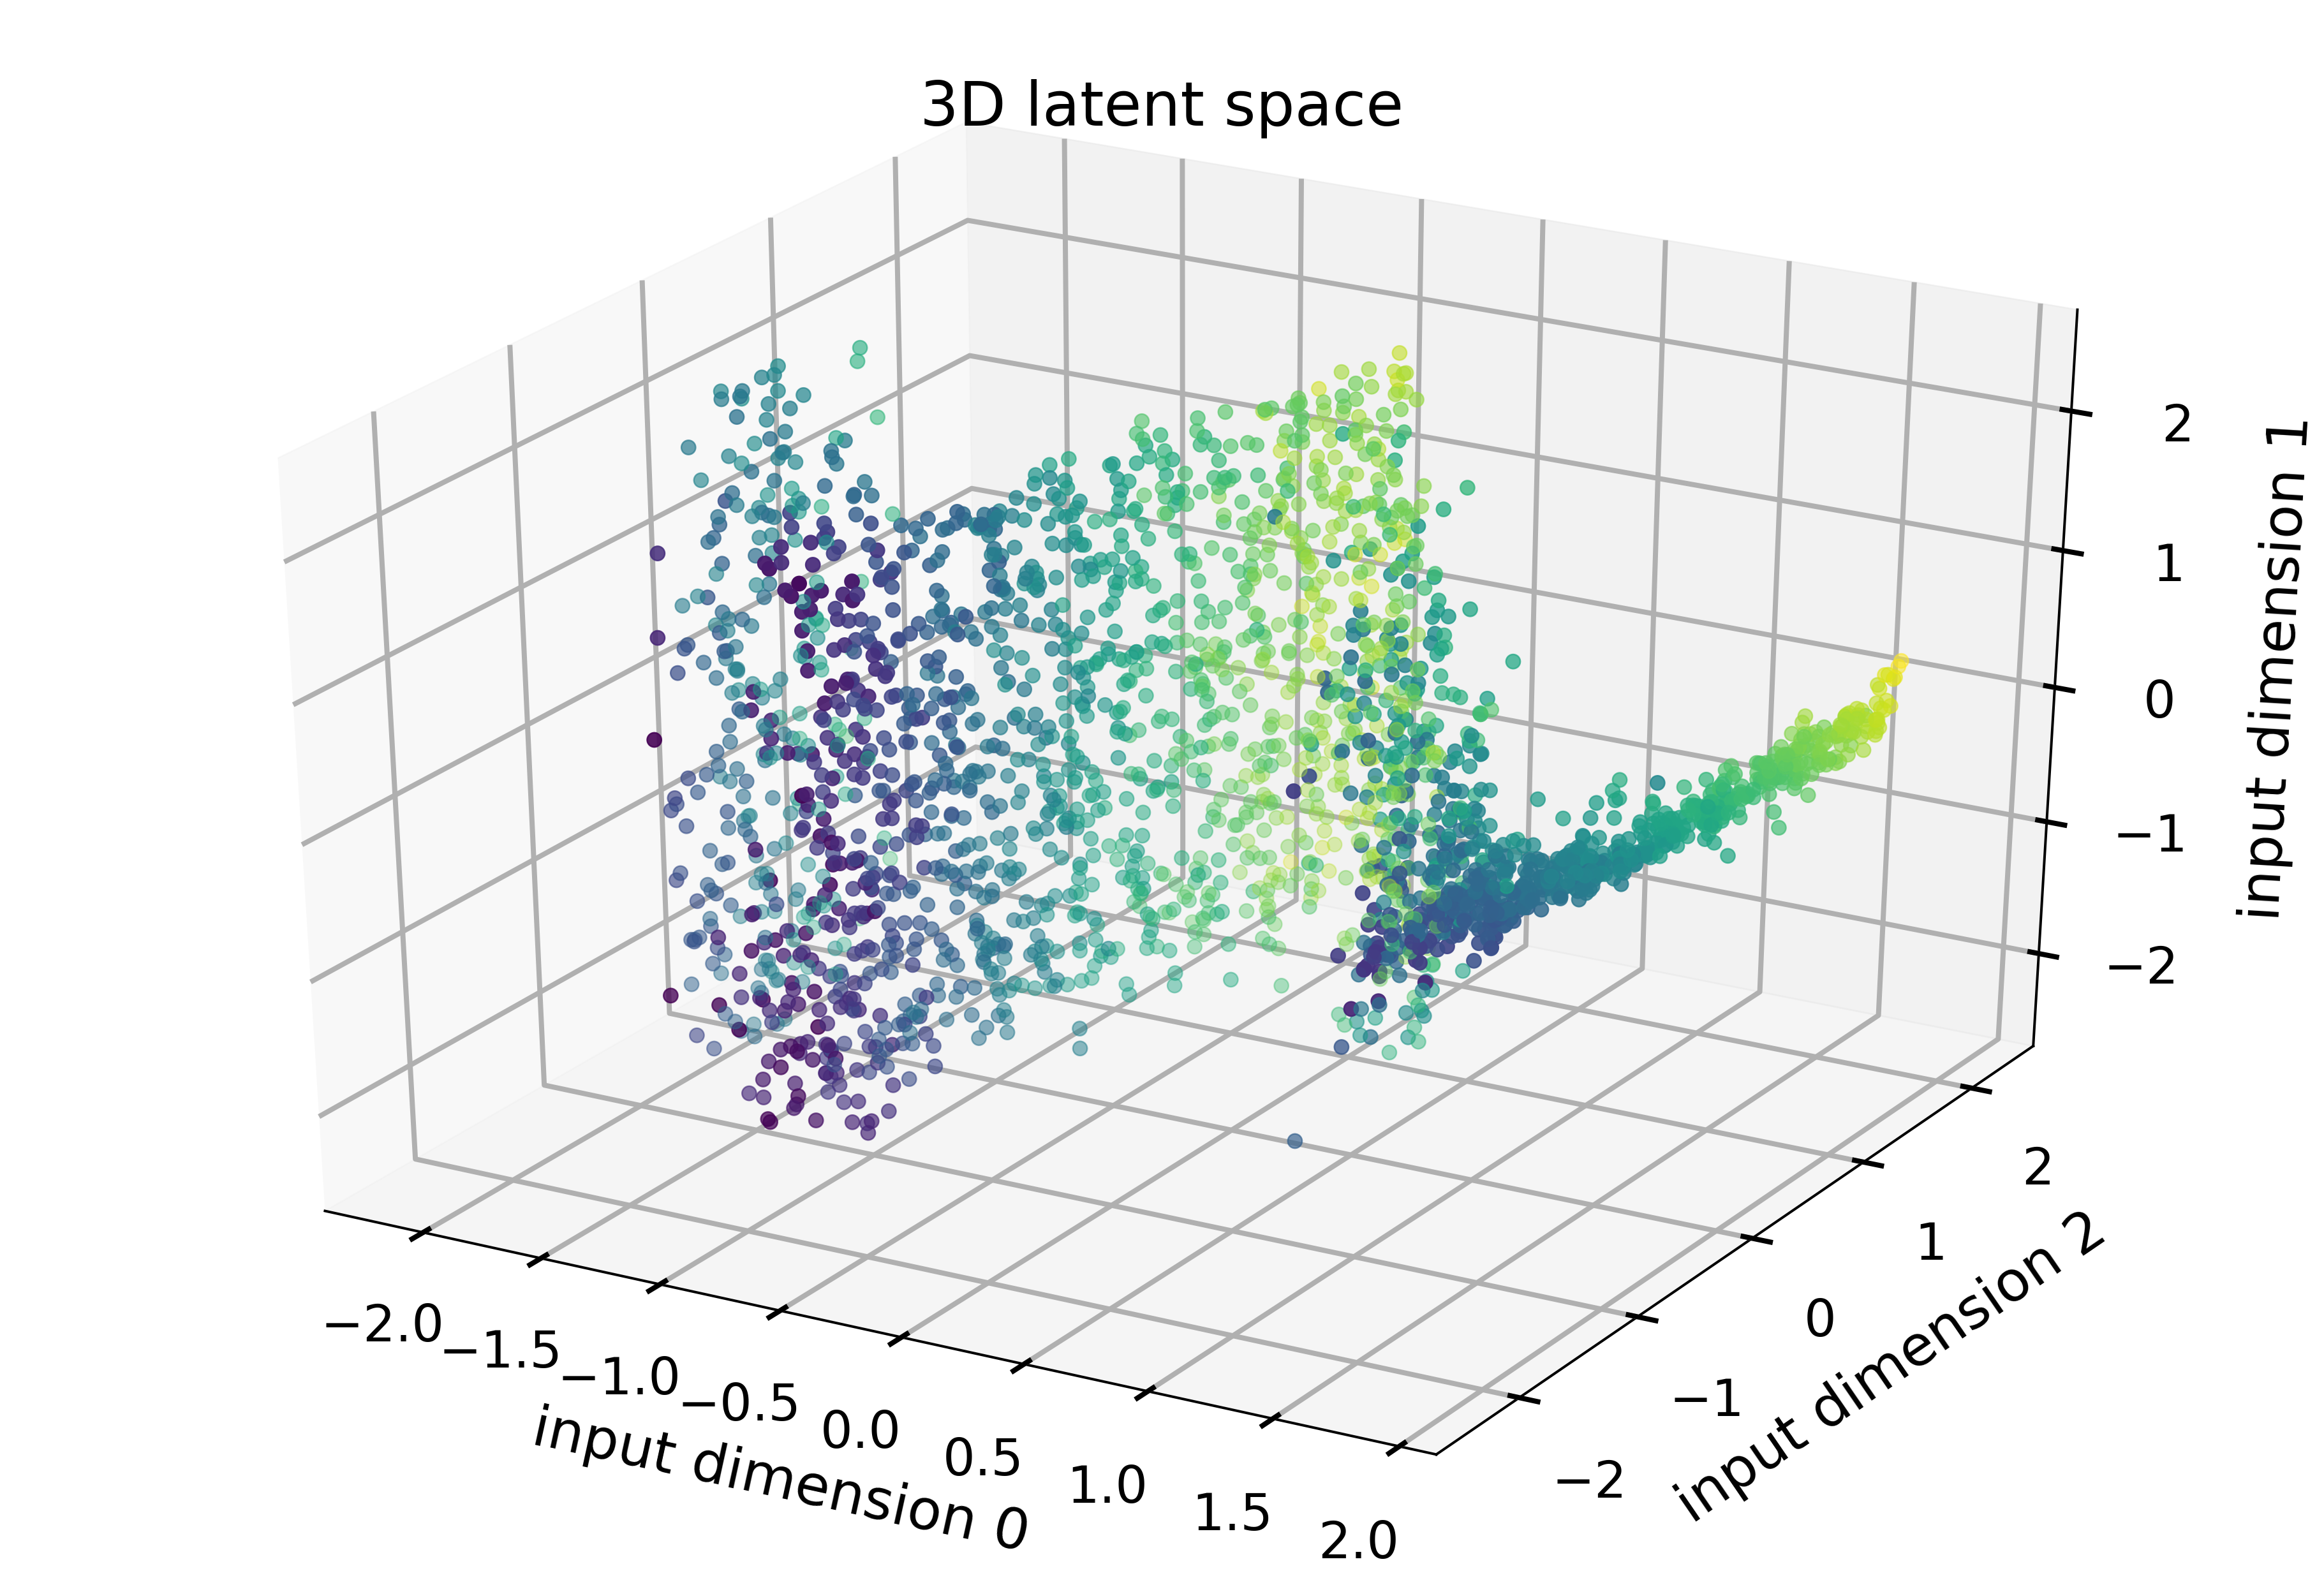

In [23]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(latent[:, input_dimension_1], latent[:,input_dimension_2], latent[:, input_dimension_3], c = latent[:, 2])
ax.set_title('3D latent space')

# Set axes label
ax.set_xlabel('input dimension ' + str(input_dimension_1), labelpad=20)
ax.set_ylabel('input dimension ' + str(input_dimension_2), labelpad=20)
ax.set_zlabel('input dimension ' + str(input_dimension_3), labelpad=20)

filename = shape_name_string + ' 3D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)



In [24]:
#Save/load the model

In [25]:
# 1: Saving a model:
filename = shape_name_string + ' BGPLVM.npy'
np.save(filename, m_GPLVM.param_array)
files.download('/content/' + filename)
print(m_GPLVM)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Name : bayesian gplvm
Objective : -18714.49973096444
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (2500, 7)  |               |        
  latent_space.variance    |               (2500, 7)  |      +ve      |        
  inducing_inputs          |                 (50, 7)  |               |        
  rbf.variance             |      0.2668922028670968  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  4.1135632731066494e-05  |      +ve      |        


In [26]:
# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(filename) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)


Name : bayesian gplvm
Objective : -18714.49973096444
Number of Parameters : 35359
Number of Optimization Parameters : 35359
Updates : True
Parameters:
  bayesian_gplvm.          |                   value  |  constraints  |  priors
  latent_space.mean        |               (2500, 7)  |               |        
  latent_space.variance    |               (2500, 7)  |      +ve      |        
  inducing_inputs          |                 (50, 7)  |               |        
  rbf.variance             |      0.2668922028670968  |      +ve      |        
  rbf.lengthscale          |                    (7,)  |      +ve      |        
  Gaussian_noise.variance  |  4.1135632731066494e-05  |      +ve      |        
